In [2]:
%matplotlib ipympl
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.ndimage import gaussian_filter
#from vizlib import *

In [6]:
#filename = "./amatter_28_11_2023-2.xyzv"
filename = "/media/matt/SCRATCH/ActiveMatterWorms/data_01_12_2023-3/amatter.xyzv"
frames = []
worms_start_end = []
fluid_start_end = []
with open(filename) as f:
    N = int(f.readline().strip())
    print(N," particles per frame")
    f.seek(0)
    line_count = 0
    for line in f:
        line_count += 1
        if (str(N) in line.strip()) and ("A" not in line.strip()) and ("B" not in line.strip()) and ("S" not in line.strip()) and ("I" not in line.strip()) and ("E" not in line.strip()):
            frames.append([line.strip(),line_count+1,line_count+N+1]) # number of particles, data start, data end
print("Loading ",len(frames)," frames of data...")
print(frames)

# counting number of worms and number of fluid particles in each frame
with open(filename) as f:
    raw_data = f.readlines()[frames[0][1]:frames[0][2]]
    for iline in range(len(raw_data)):
        line = raw_data[iline]
        raw_data[iline] = line.strip()
    worm_count = 0
    fluid_count = 0
    worm_line_start = 0
    worm_line_end = 0
    fluid_line_start_offset = 0
    fluid_line_start = 0
    fluid_line_end = 0
    for (i,line) in enumerate(raw_data):
        if ("A" not in line) and ("B" not in line) and ("I" not in line) and ("E" not in line): # then it must be a fluid particle
            fluid_count += 1
            if fluid_line_start == 0:
                fluid_line_start = i
        if ("S" not in line) and ("I" not in line) and ("E" not in line):
            worm_count += 1

worm_line_start = frames[0][1]
worm_line_end = worm_line_start + worm_count - 3 #idk why this is 3
fluid_line_end = fluid_line_start + fluid_count
fluid_line_start_offset = fluid_line_start - worm_line_end
print("# of fluid particles",fluid_count,fluid_line_start,fluid_line_end,fluid_line_start_offset)
print("# of worm particles",worm_count)

worm_pos_data = np.zeros((len(frames),worm_count,3))
worm_vel_data = np.zeros((len(frames),worm_count,3))
fluid_pos_data = np.zeros((len(frames),fluid_count,3))
fluid_vel_data = np.zeros((len(frames),fluid_count,3))
with open(filename) as f:
    #frame_data = np.zeros((N,6))
    raw_data = f.readlines()
    for iline in range(len(raw_data)):
        line = raw_data[iline]
        raw_data[iline] = line.strip()
    for frame in tqdm.tqdm(range(len(frames))):
        data_line_start = frames[frame][1]
        data_line_end = frames[frame][2]
        raw_frame_data_list = raw_data[data_line_start:data_line_end] # strips "A/B"

        fluid_line_start = 0
        for (i,line) in enumerate(raw_frame_data_list):
            if ("A" not in line) and ("B" not in line) and ("I" not in line) and ("E" not in line): # then it must be a fluid particle
                if fluid_line_start == 0:
                    fluid_line_start = i

        fluid_line_end = fluid_line_start + fluid_count
        worm_line_start = frames[frame][1]
        worm_line_end = worm_line_start + worm_count - 3 #idk why this is 3

        for (i,line) in enumerate(raw_frame_data_list[worm_line_start:worm_line_end]):
            line_data = [float(val) for val in line[1:].split()]
            worm_pos_data[frame,i,:] = line_data[0:3]
            worm_vel_data[frame,i,:] = line_data[3:6]
        
        for (i,line) in enumerate(raw_frame_data_list[fluid_line_start:fluid_line_end]):
            line_data = [float(val) for val in line[1:].split()]
            fluid_pos_data[frame,i,:] = line_data[0:3]
            fluid_vel_data[frame,i,:] = line_data[3:6]



19204  particles per frame
Loading  1001  frames of data...
[['19204', 2, 19206], ['19204', 19208, 38412], ['19204', 38414, 57618], ['19204', 57620, 76824], ['19204', 76826, 96030], ['19204', 96032, 115236], ['19204', 115238, 134442], ['19204', 134444, 153648], ['19204', 153650, 172854], ['19204', 172856, 192060], ['19204', 192062, 211266], ['19204', 211268, 230472], ['19204', 230474, 249678], ['19204', 249680, 268884], ['19204', 268886, 288090], ['19204', 288092, 307296], ['19204', 307298, 326502], ['19204', 326504, 345708], ['19204', 345710, 364914], ['19204', 364916, 384120], ['19204', 384122, 403326], ['19204', 403328, 422532], ['19204', 422534, 441738], ['19204', 441740, 460944], ['19204', 460946, 480150], ['19204', 480152, 499356], ['19204', 499358, 518562], ['19204', 518564, 537768], ['19204', 537770, 556974], ['19204', 556976, 576180], ['19204', 576182, 595386], ['19204', 595388, 614592], ['19204', 614594, 633798], ['19204', 633800, 653004], ['19204', 653006, 672210], ['19204',

100%|██████████| 1001/1001 [00:14<00:00, 70.61it/s]


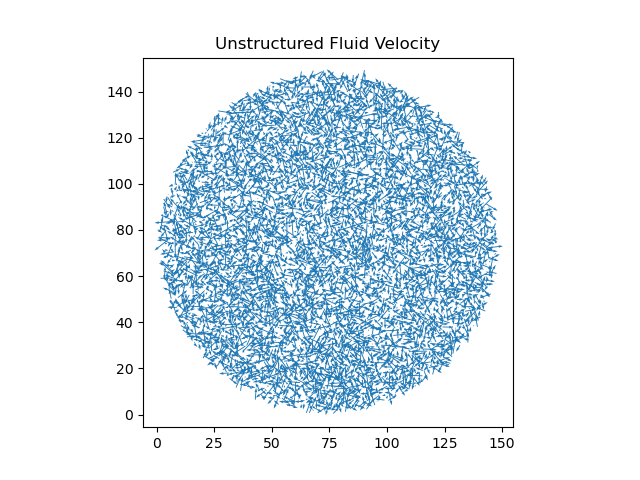

In [7]:
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(fluid_pos_data[-1,:,0], #x
                   fluid_pos_data[-1,:,1], #y
                   fluid_vel_data[-1,:,0], #u
                   fluid_vel_data[-1,:,1], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Fluid Velocity")
plt.show()

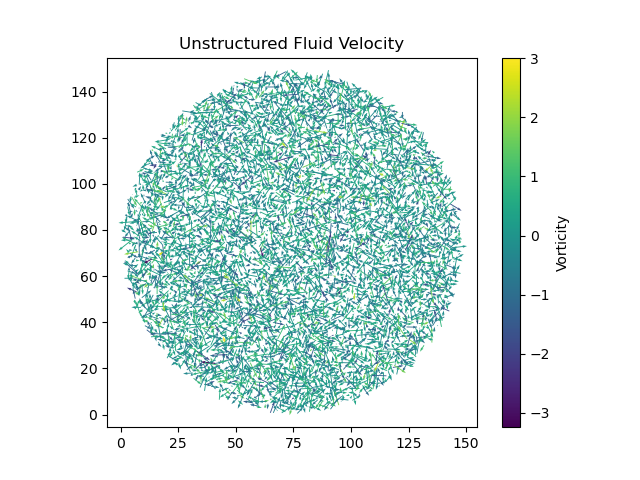

In [8]:
vorticity = np.gradient(fluid_vel_data[-1,:,1], axis=0) - np.gradient(fluid_vel_data[-1,:,0], axis=0)
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(fluid_pos_data[-1,:,0], #x
                   fluid_pos_data[-1,:,1], #y
                   fluid_vel_data[-1,:,0], #u
                   fluid_vel_data[-1,:,1], #v,
                   vorticity,
                   pivot='mid',
                   #color=vorticity,
                   cmap='viridis',
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
cbar = plt.colorbar(quiver, ax=ax)
cbar.set_label('Vorticity')
ax.set_title("Unstructured Fluid Velocity")
plt.show()

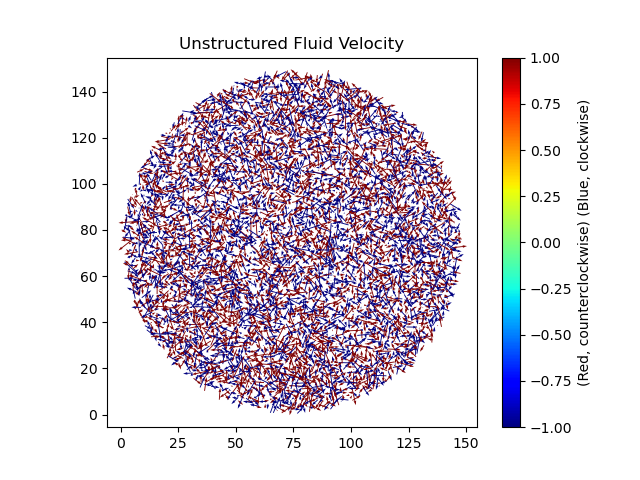

In [9]:
vorticity = np.gradient(fluid_vel_data[-1,:,1], axis=0) - np.gradient(fluid_vel_data[-1,:,0], axis=0)
rot_dir = np.sign(vorticity)
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(fluid_pos_data[-1,:,0], #x
                   fluid_pos_data[-1,:,1], #y
                   fluid_vel_data[-1,:,0], #u
                   fluid_vel_data[-1,:,1], #v,
                   rot_dir,
                   pivot='mid',
                   #color=vorticity,
                   cmap='jet',
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
cbar = plt.colorbar(quiver, ax=ax)
cbar.set_label('(Red, counterclockwise) (Blue, clockwise)')
ax.set_title("Unstructured Fluid Velocity")
plt.show()

X: 1.48656 147.35 145.86344
Y: 1.80222 147.436 145.63378


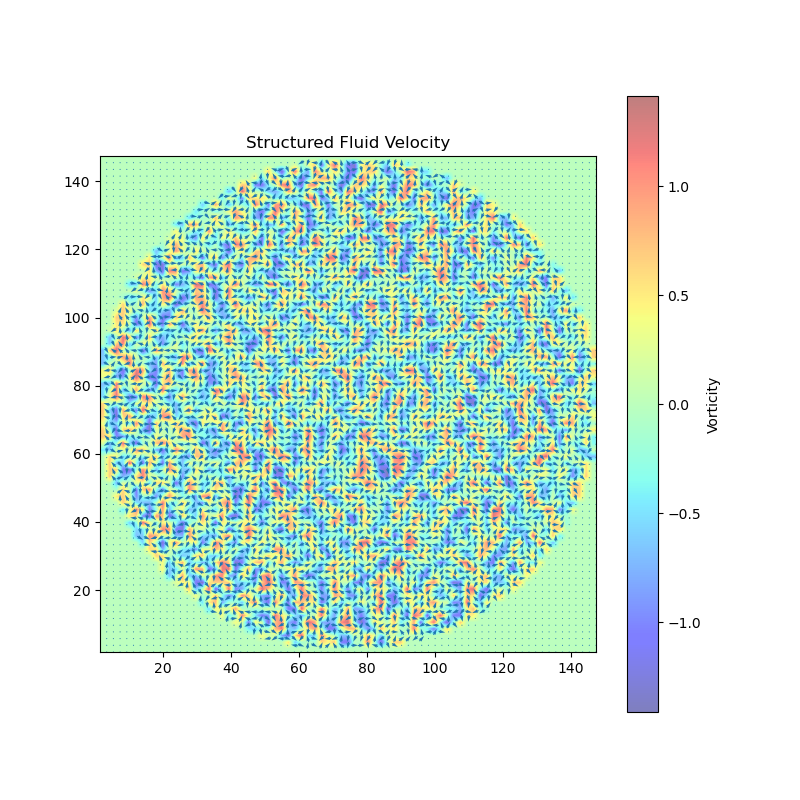

In [13]:
#extend of the particles in +x,-x,+y,-y
vector_field = np.zeros((fluid_count,6))
vector_field[:,0:3] = fluid_pos_data[-1,:,:]
vector_field[:,3:6] = fluid_vel_data[-1,:,:]

num_interpolation_points = 75
interpolation_type = "linear"
max_x = np.max(vector_field[:,0])
min_x = np.min(vector_field[:,0])
max_y = np.max(vector_field[:,1])
min_y = np.min(vector_field[:,1])
print("X:",min_x,max_x,max_x-min_x)
print("Y:",min_y,max_y,max_y-min_y)

# create structured grid
#num_interpolation_points = 100
grid_x,grid_y = np.meshgrid(np.linspace(min_x,max_x,num=num_interpolation_points),
                            np.linspace(min_y,max_y,num=num_interpolation_points))
# Create points for interpolation
points = np.column_stack((vector_field[:,0], vector_field[:,1]))
# Interpolate the x and y components separately using bilinear interpolation
grid_u = interpolate.griddata(points, vector_field[:,3], (grid_x, grid_y), method=interpolation_type)
grid_v = interpolate.griddata(points, vector_field[:,4], (grid_x, grid_y), method=interpolation_type)
# merged everything back together to make single object
structured_vector_field = np.column_stack((grid_x.flatten(), grid_y.flatten(), grid_u.flatten(), grid_v.flatten()))
# normalize the vector parts
n = np.sqrt(structured_vector_field[:,2] ** 2 + structured_vector_field[:,3] ** 2)
structured_vector_field[:,2] = structured_vector_field[:,2]/n
structured_vector_field[:,3] = structured_vector_field[:,3]/n

# replace nans with 0.0
np.nan_to_num(structured_vector_field[:,2], copy=False, nan=0.0)
np.nan_to_num(structured_vector_field[:,3], copy=False, nan=0.0)

"""plotting the vectors of each grid"""
vorticity = np.gradient(structured_vector_field[:,3], axis=0) - np.gradient(structured_vector_field[:,2], axis=0)
vorticity_grid = np.reshape(vorticity,(num_interpolation_points,num_interpolation_points))
fig,ax = plt.subplots(1,1,figsize=(8,8))
quiver = ax.quiver(structured_vector_field[:,0], #x
                   structured_vector_field[:,1], #y
                   structured_vector_field[:,2], #u
                   structured_vector_field[:,3], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
pcm = ax.imshow(vorticity_grid,cmap="jet",interpolation="bilinear",alpha=0.5,origin="lower",extent=(structured_vector_field[:,0][0],structured_vector_field[:,0][-1],structured_vector_field[:,1][0],structured_vector_field[:,1][-1]))
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label('Vorticity')
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Structured Fluid Velocity")
plt.show()

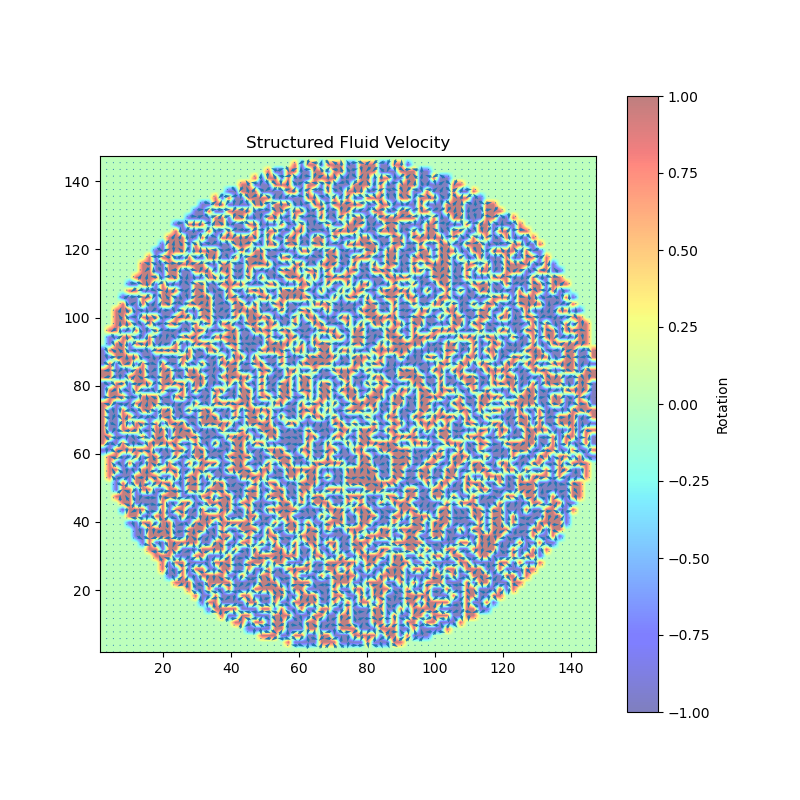

In [20]:
vorticity = np.gradient(structured_vector_field[:,3], axis=0) - np.gradient(structured_vector_field[:,2], axis=0)
vorticity_grid = np.reshape(vorticity,(num_interpolation_points,num_interpolation_points))
rot_dir_grid = np.sign(vorticity_grid)
fig,ax = plt.subplots(1,1,figsize=(8,8))
quiver = ax.quiver(structured_vector_field[:,0], #x
                   structured_vector_field[:,1], #y
                   structured_vector_field[:,2], #u
                   structured_vector_field[:,3], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.5
)
pcm = ax.imshow(rot_dir_grid,cmap="jet",interpolation="bilinear",alpha=0.5,origin="lower",extent=(structured_vector_field[:,0][0],structured_vector_field[:,0][-1],structured_vector_field[:,1][0],structured_vector_field[:,1][-1]))
cbar = plt.colorbar(pcm, ax=ax)
cbar.set_label('Rotation')
ax.axis("scaled")
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Structured Fluid Velocity")
plt.show()

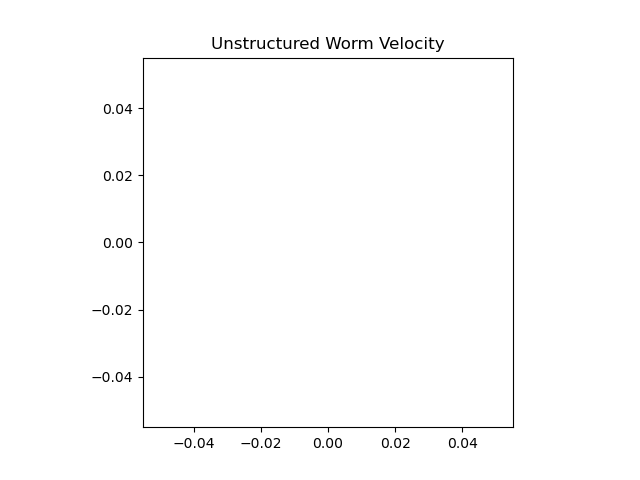

In [22]:
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(worm_pos_data[-1,:,0], #x
                   worm_pos_data[-1,:,1], #y
                   worm_vel_data[-1,:,0], #u
                   worm_vel_data[-1,:,1], #v
                   pivot='mid',
                   color="tab:blue",
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
ax.set_title("Unstructured Worm Velocity")
plt.show()

/home/matt/anaconda3/lib/python3.11/site-packages/matplotlib/quiver.py:603: RuntimeWarning: invalid value encountered in divide
  lengths = np.hypot(*dxy.T) / eps


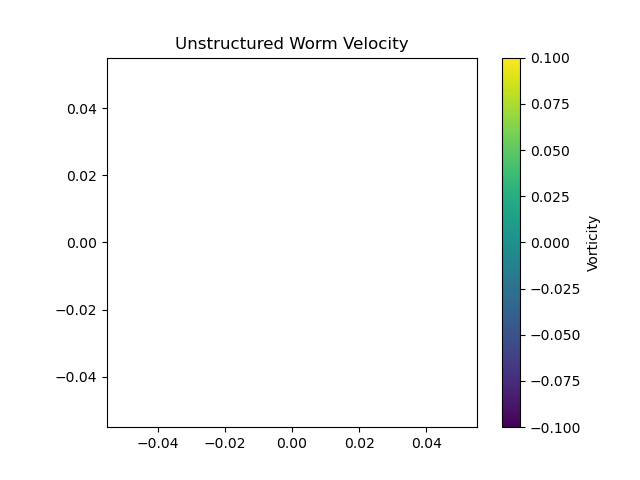

In [23]:
vorticity = np.gradient(worm_vel_data[-1,:,1], axis=0) - np.gradient(worm_vel_data[-1,:,0], axis=0)
fig,ax = plt.subplots(1,1)
quiver = ax.quiver(worm_pos_data[-1,:,0], #x
                   worm_pos_data[-1,:,1], #y
                   worm_vel_data[-1,:,0], #u
                   worm_vel_data[-1,:,1], #v,
                   vorticity,
                   pivot='mid',
                   #color=vorticity,
                   cmap='viridis',
                   scale_units='xy',
                   scale=0.25
)
ax.set_box_aspect(1)
ax.set_adjustable("datalim")
cbar = plt.colorbar(quiver, ax=ax)
cbar.set_label('Vorticity')
ax.set_title("Unstructured Worm Velocity")
plt.show()